# Image Data Augmentation and Generator with Keras

In this notebook, we will perform data augmentation and automatically label the images with the help of Keras’ ImageDataGenerator class. 

Data augmentation encompasses a wide range of techniques used to generate "new" training samples from the original ones by applying random jitters and perturbations (but at the same time ensuring that the class labels of the data are not changed). Our goal when applying data augmentation is to increase the generalizability of the model. Image data augmentation artificially creates training images through different ways such as random rotation, shifts, shear and flips, etc.

Keras ImageDataGenerator class works by:

-  Accepting a batch of images used for training.
-  Taking this batch and applying a series of random transformations to each image in the batch (including random rotation, resizing, shearing, etc.).
-  Replacing the original batch with the new, randomly transformed batch.
-  Training the CNN on this randomly transformed batch (i.e., the original data itself is not used for training).

[Ref](https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/)

In [1]:
%matplotlib inline
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
import matplotlib.pyplot as plt
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.preprocessing import image
from tensorflow.keras.models import clone_model

Using TensorFlow backend.


## 1. Data File Pre-Processing

The following python code will use the OS library to use Operating System libraries, giving us access to the file system, and the zipfile library allowing us to unzip the data. 

### 1.1 File Pre-Processing

In [2]:
# training and development dataset

zipfile_path = 'data/cats_dogs_train.zip'
zip_file = zipfile.ZipFile(zipfile_path, 'r') # Open a ZIP file
zip_file.extractall(path = 'data/') # Extract all members from the archive

zipfile_path = 'data/cats_dogs_validation.zip'
zip_file = zipfile.ZipFile(zipfile_path, 'r') # Open a ZIP file
zip_file.extractall(path = 'data/') # Extract all members from the archive

zip_file.close() # Close the archive file

The contents of the .zip are extracted to the base directory `data/cats_dogs_train/train` (for training) and `data/cats_dogs_validation/validation` (for development), which in turn each contains `cats` and `dogs` subdirectories.

We do not explicitly label the images as cats or dogs. We'll use Image Generator -- and this is coded to read images from subdirectories, and automatically label them from the name of that subdirectory. 

In [3]:
# Directory with our training cat pictures
train_cat_dir = os.path.join('data/cats_dogs_train/train/cats')
# Directory with our training dog pictures
train_dog_dir = os.path.join('data/cats_dogs_train/train/dogs')
# Directory with our dev cat pictures
dev_cat_dir = os.path.join('data/cats_dogs_validation/validation/cats')
# Directory with our dev dog pictures
dev_dog_dir = os.path.join('data/cats_dogs_validation/validation/dogs')

Now, let's see what the filenames look like in the `cats` and `dogs` directories:

In [4]:
# print some filenames in the cats and dogs directories

train_cat_names = os.listdir(train_cat_dir)
print('training cat names: ' + str(train_cat_names[:5]))

train_dog_names = os.listdir(train_dog_dir)
print('training dog names: ' + str(train_dog_names[:5]))

dev_cat_names = os.listdir(dev_cat_dir)
print('dev cat names: ' + str(dev_cat_names[:5]))

dev_dog_names = os.listdir(dev_dog_dir)
print('dev dog names: ' + str(dev_dog_names[:5]))

training cat names: ['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.101.jpg']
training dog names: ['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg']
dev cat names: ['cat.2000.jpg', 'cat.2001.jpg', 'cat.2002.jpg', 'cat.2003.jpg', 'cat.2004.jpg']
dev dog names: ['dog.2000.jpg', 'dog.2001.jpg', 'dog.2002.jpg', 'dog.2003.jpg', 'dog.2004.jpg']


Let's find out the total number of cat and dog images in the directories.

In [5]:
print('total training cat images:', len(train_cat_names))
print('total training dog images:', len(train_dog_names))
print('total dev cat images:', len(dev_cat_names))
print('total dev dog images:', len(dev_dog_names))

total training cat images: 1000
total training dog images: 1000
total dev cat images: 500
total dev dog images: 500


### 1.2 Image Data Examples
Now let's take a look at a few pictures to get a better sense of what they look like.

In [6]:
# we'll output images in a nrows x ncols configuration

nrows = 4
ncols = 4

train_cat_paths = [os.path.join(train_cat_dir, fname) for fname in train_cat_names]
train_dog_paths = [os.path.join(train_dog_dir, fname) for fname in train_dog_names]
dev_cat_paths = [os.path.join(dev_cat_dir, fname) for fname in dev_cat_names]
dev_dog_paths = [os.path.join(dev_dog_dir, fname) for fname in dev_dog_names]

Display a batch of 8 cat and 8 dog pictures.

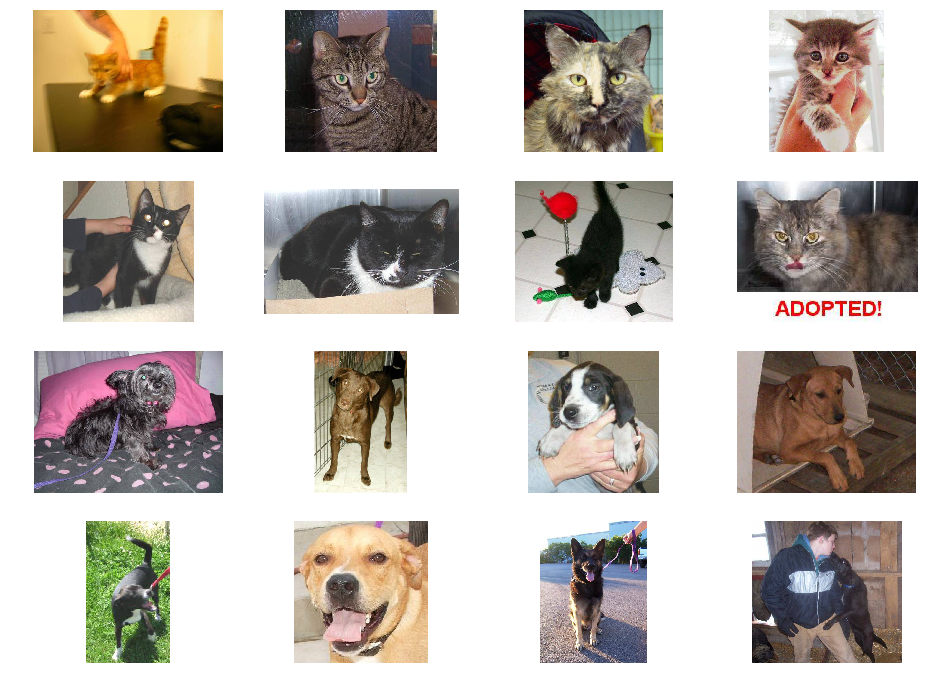

In [7]:
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 3)

# iterating over 16 images
for i, img_path in enumerate(train_cat_paths[0:4] + dev_cat_paths[0:4] + train_dog_paths[0:4] + dev_dog_paths[0:4]):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img)

## 2. Image Data Augmentation and Generator 

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of images of size 150x150 and their labels (binary).

Data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network (it is uncommon to feed raw pixels into a convnet). In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows us to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit_generator`, `evaluate_generator`, and `predict_generator`.

**Image Augmentation**

There are properties on  ImageGenerator that we can use to augment the image. 

```
# Updated to do image augmentation
train_datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
```
These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

* rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
* width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
* shear_range is for randomly applying shearing transformations.
* zoom_range is for randomly zooming inside pictures.
* horizontal_flip is for randomly flipping half of the images horizontally. This is relevant when there are no assumptions of horizontal assymmetry (e.g. real-world pictures).
* fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.


In [8]:
# create image data

# training set without image data augmentation for comparison
train_gen = ImageDataGenerator(rescale = 1/255) 
train_generator = train_gen.flow_from_directory(
    'data/cats_dogs_train/train',  # This is the source directory for training images
    target_size = (150, 150),  # All images will be resized to this dimension
    batch_size = 20,
    class_mode = 'binary')

# training set with image data augmentation
train_gen_aug = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')
train_generator_aug = train_gen_aug.flow_from_directory(
    'data/cats_dogs_train/train',  # This is the source directory for training images
    target_size = (150, 150),  # All images will be resized to this dimension
    batch_size = 20,
    class_mode = 'binary')

# dev set
dev_gen = ImageDataGenerator(rescale = 1/255)
dev_generator = dev_gen.flow_from_directory(
    'data/cats_dogs_validation/validation/',  # This is the source directory for dev images
    target_size = (150, 150),  # All images will be resized to this dimension
    batch_size = 20,
    class_mode = 'binary')

# print class indices
print("Class index: "  + str(train_generator.class_indices))

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Class index: {'cats': 0, 'dogs': 1}


## 3. Build the CNN Model

We add convolutional and pooling layers, and then flatten the result to feed into densely connected layers.

Note that because we are facing a two-class classification problem, i.e. a **binary classification problem**, we will end our network with a **sigmoid** activation, so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

In [9]:
model = tf.keras.models.Sequential([
    # The first convolution and pooling
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution and pooling
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution and pooling
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution and pooling
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512-neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # output neuron
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

## 4. Model Training and Comparison

We will compare the performance of the model trained with and without data augmentation.

In [11]:
# A callback is a set of functions to be applied at given stages of the training procedure. 
# We can use callbacks to get a view on internal states and statistics of the model during training. 
# We can pass a list of callbacks (as the keyword argument callbacks) to the .fit() method of the Sequential 
# or Model classes. 
# The relevant methods of the callbacks will then be called at each stage of the training.

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('acc') > 0.98):
            print("\nReached target accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

In [12]:
# create function to plot the training progress

def plot_progress(history, title):
    """
    Plot the loss and accuracy of training and validation data, as functions of epochs
    
    Arguments:
    history: the History object returned by model.fit_generator() 
    title: the title of the graph 
    """

    train_loss = history.history['loss']
    train_acc = history.history['acc']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_acc']
    epochs = range(len(train_acc))
    
    fig, axes = plt.subplots(1, 2)
    fig.suptitle(title, fontsize = 20)
    fig.set_size_inches(16, 5)
    axes[0].plot(epochs, train_acc, 'bo', label = 'Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
    axes[0].set_title('Accuracy')
    axes[0].legend()
    axes[1].plot(epochs, train_loss, 'bo', label = 'Training Loss')
    axes[1].plot(epochs, val_loss, 'b', label = 'Validation Loss')
    axes[1].set_title('Loss')
    axes[1].legend()
    plt.show()

### 4.1 Without Data Augmentation

We will train our model with the `binary_crossentropy` loss. We will use the `RMSprop` optimizer with a learning rate of `0.0001`. During training, we will want to monitor classification accuracy.

In [13]:
model_no_aug = clone_model(model)
model_no_aug.compile(loss = 'binary_crossentropy',
                     optimizer = RMSprop(lr = 1e-4),
                     metrics = ['acc'])

In [14]:
history_no_aug = model_no_aug.fit_generator(
      train_generator,
      steps_per_epoch = 100, # number of images = batch_size * steps
      epochs = 100,
      verbose = 1,
      validation_data = dev_generator,
      validation_steps = 50, # number of images = batch_size * steps
      callbacks = [callbacks])

Epoch 1/100
100/100 [==============================] - 75s 750ms/step - loss: 0.6857 - acc: 0.5565 - val_loss: 0.6648 - val_acc: 0.5960
Epoch 2/100
100/100 [==============================] - 72s 724ms/step - loss: 0.6517 - acc: 0.6185 - val_loss: 0.6209 - val_acc: 0.6590
Epoch 3/100
100/100 [==============================] - 73s 735ms/step - loss: 0.5961 - acc: 0.6855 - val_loss: 0.5979 - val_acc: 0.6730
Epoch 4/100
100/100 [==============================] - 73s 729ms/step - loss: 0.5569 - acc: 0.7095 - val_loss: 0.5760 - val_acc: 0.6980
Epoch 5/100
100/100 [==============================] - 71s 714ms/step - loss: 0.5327 - acc: 0.7320 - val_loss: 0.5824 - val_acc: 0.7130
Epoch 6/100
100/100 [==============================] - 72s 717ms/step - loss: 0.5166 - acc: 0.7360 - val_loss: 0.6024 - val_acc: 0.6830
Epoch 7/100
100/100 [==============================] - 71s 714ms/step - loss: 0.5010 - acc: 0.7555 - val_loss: 0.5624 - val_acc: 0.7120
Epoch 8/100
100/100 [===========================

#### Plot the training progress

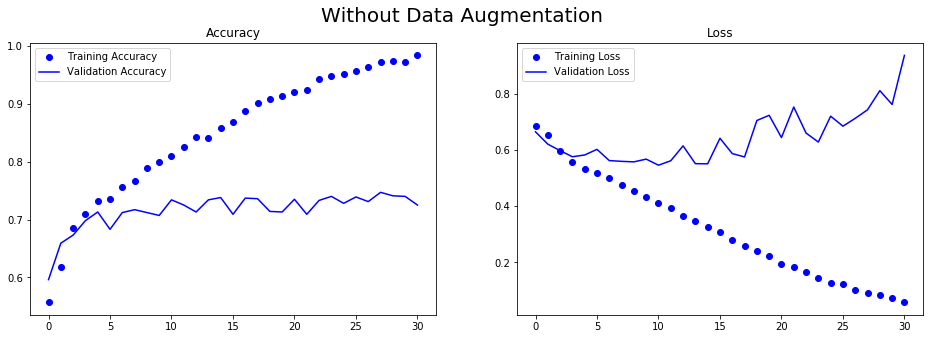

In [15]:
plot_progress(history_no_aug, 'Without Data Augmentation')

The Training Accuracy is close to 100%, and the validation accuracy is in the 70%-80% range. This is a great example of overfitting -- which in short means that it can do very well with images it has seen before, but not so well with images it hasn't.  One simple method to avoid overfitting is to augment the images a bit. If you think about it, most pictures of a cat are very similar -- the ears are at the top, then the eyes, then the mouth etc. Things like the distance between the eyes and ears will always be quite similar too. 

What if we tweak the images -- rotate the image, squash it, etc.  That's what image augementation is all about.

### 4.2 With Data Augmentation

We will train our model with the `binary_crossentropy` loss. We will use the `RMSprop` optimizer with a learning rate of `0.0001`. During training, we will want to monitor classification accuracy.

In [16]:
model_aug = clone_model(model)
model_aug.compile(loss = 'binary_crossentropy',
                  optimizer = RMSprop(lr = 1e-4),
                  metrics = ['acc'])

In [17]:
history_aug = model_aug.fit_generator(
      train_generator_aug,
      steps_per_epoch = 100,   # number of images = batch_size * steps
      epochs = 100,
      verbose = 1,
      validation_data = dev_generator,
      validation_steps = 50,  # number of images = batch_size * steps
      callbacks = [callbacks])

Epoch 1/100
100/100 [==============================] - 89s 888ms/step - loss: 0.6914 - acc: 0.5275 - val_loss: 0.6764 - val_acc: 0.5630
Epoch 2/100
100/100 [==============================] - 79s 785ms/step - loss: 0.6772 - acc: 0.5685 - val_loss: 0.6490 - val_acc: 0.6240
Epoch 3/100
100/100 [==============================] - 85s 855ms/step - loss: 0.6586 - acc: 0.5875 - val_loss: 0.6392 - val_acc: 0.6030
Epoch 4/100
100/100 [==============================] - 75s 755ms/step - loss: 0.6440 - acc: 0.6245 - val_loss: 0.6100 - val_acc: 0.6500
Epoch 5/100
100/100 [==============================] - 87s 870ms/step - loss: 0.6277 - acc: 0.6470 - val_loss: 0.5881 - val_acc: 0.6940
Epoch 6/100
100/100 [==============================] - 75s 752ms/step - loss: 0.6185 - acc: 0.6455 - val_loss: 0.6122 - val_acc: 0.6390
Epoch 7/100
100/100 [==============================] - 85s 849ms/step - loss: 0.5993 - acc: 0.6695 - val_loss: 0.5740 - val_acc: 0.6920
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 76s 761ms/step - loss: 0.4153 - acc: 0.8150 - val_loss: 0.4175 - val_acc: 0.7960
Epoch 62/100
100/100 [==============================] - 87s 871ms/step - loss: 0.4202 - acc: 0.8005 - val_loss: 0.4461 - val_acc: 0.7790
Epoch 63/100
100/100 [==============================] - 79s 788ms/step - loss: 0.4306 - acc: 0.8015 - val_loss: 0.4294 - val_acc: 0.8000
Epoch 64/100
100/100 [==============================] - 87s 867ms/step - loss: 0.4028 - acc: 0.8225 - val_loss: 0.4496 - val_acc: 0.7870
Epoch 65/100
100/100 [==============================] - 76s 762ms/step - loss: 0.4047 - acc: 0.8110 - val_loss: 0.4228 - val_acc: 0.7990
Epoch 66/100
100/100 [==============================] - 90s 896ms/step - loss: 0.4087 - acc: 0.8140 - val_loss: 0.4161 - val_acc: 0.8070
Epoch 67/100
100/100 [==============================] - 79s 787ms/step - loss: 0.3981 - acc: 0.8180 - val_loss: 0.4838 - val_acc: 0.7650
Epoch 68/100
100/100 [===================

#### Plot the training progress

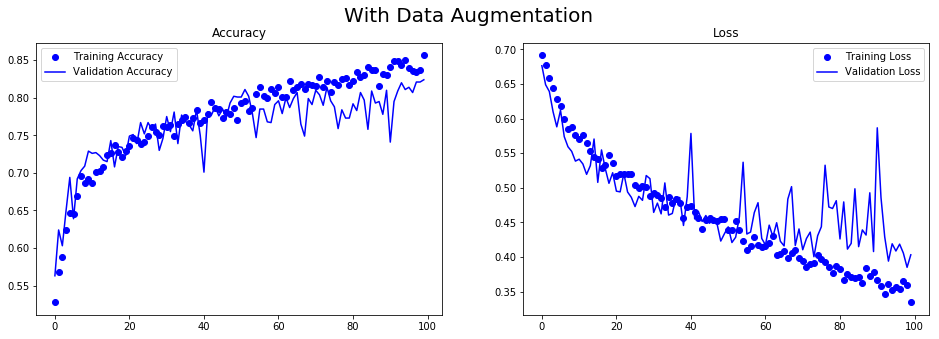

In [18]:
plot_progress(history_aug, 'With Data Augmentation')

Compared with the model trained without data augmentation, we can see that overfitting has been resolved.

## 5. Model Testing

Let's now take a look at actually running a prediction using the model. This code will allow us to choose 1 or more files from our file system, it will then upload them, and run them through the model, giving an indication of whether the object is a cat or a dog.

Our images are downloaded from https://pixabay.com/

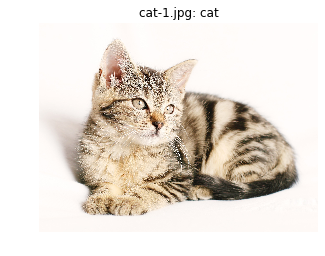

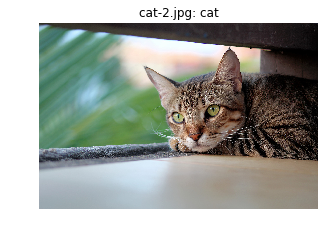

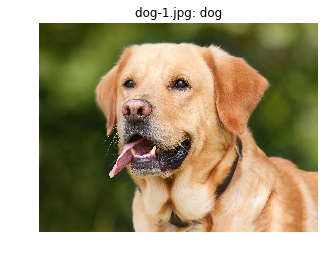

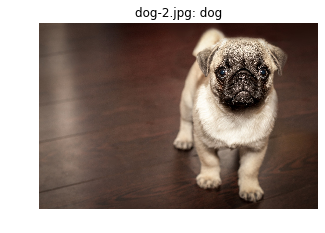

In [19]:
model_test = model_aug # choose which model to use
test_path = 'test/' # the folder that saves the test images
test_files = [os.path.join(test_path, fname) for fname in os.listdir(test_path)]

for file in test_files:
    img = image.load_img(file, target_size = (150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    x /= 255
    
    # predict
    classes = model_test.predict(x)
    
    # show the figure with prediction
    image_cur = plt.imread(file)
    plt.figure(figsize = (5, 5))
    plt.imshow(image_cur)
    plt.axis('off')
    if classes[0] > 0.5:
        plt.title(file.split('/')[-1] + ": dog")
    else:
        plt.title(file.split('/')[-1] + ": cat")

## 6. Save Model

In [20]:
model_aug.save('my_model.h5')